These notebooks are part of Kaggle’s [Practical Model Evaluation](https://www.kaggle.com/practical-model-evaluation) event, which ran from December 3-5 2019. You can find the [livestreams for this event here](https://youtu.be/7RdKnACscjA?list=PLqFaTIg4myu-HA1VGJi_7IGFkKRoZeOFt).

* Day 1 Notebook: [Figuring out what matters for you](https://www.kaggle.com/rtatman/practical-model-evaluation-day-1)
* Day 2 Notebook: [Training models with automated machine learning](https://www.kaggle.com/rtatman/practical-model-evaluation-day-2)
* Day 3 Notebook: [Evaluating our models](https://www.kaggle.com/rtatman/practical-model-evaluation-day-3)

***

Today we're going to be evaluating our models using several different metrics: 

1. How long did they take to train?
2. How long does it take them to do batch inference on the held out data?
3. What's their overall accuracy? 
4. How well do they perform across cases?
5. How does their performance change if we change one of our input features?

Let's get coding! First, we'll need to load in all the libraries and data we'll need.

In [41]:
import random
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import category_encoders as ce
from xgboost import XGBClassifier
import h2o
from h2o.automl import H2OAutoML

# set seed for reproducability
random.seed()

training_data = pd.read_csv("data/model_input/train_data_2018.csv")
testing_data = pd.read_csv("data/model_input/test_data_2018.csv")

# save out copy of testing data to use w/ GCP
with open("test_data_2018.csv", "+w") as file:
    testing_data.to_csv(file, index=False, na_rep='NA')

# split into predictors & target variables
X_training = training_data.drop("job_title", axis=1)
y_training = training_data["job_title"]

X_testing = testing_data.drop("job_title", axis=1)
y_testing = testing_data["job_title"]

# encoded copy of our training data for training TPOT model
encoder_X = ce.OrdinalEncoder()
X_encoded = encoder_X.fit_transform(X_training)
X_testing_encoded = encoder_X.transform(X_testing)

encoder_y = ce.OrdinalEncoder()
y_encoded = encoder_y.fit_transform(y_training)

# Load in our models

Next we need to load in all our models that we trained yesterday.

> **Tip:** If you want to use your own models, you can add your notebook from yesterday by clicking on [+ Add Data] in the upper right hand corner, then [Kernel Output Files] and search for your notebook. You'll need to have committed your notebook first, though!

For the TPOT model, we're training a new version of the winning pipeline.

In [42]:
# load our saved XGBoost model
xgboost_model = XGBClassifier()
xgboost_model.load_model("models/xgboost_baseline.model")
xgboost_model._le = LabelEncoder().fit(training_data["job_title"])

# initilaize H2o instance & load winning AutoML model
h2o.init()
h2o_model = h2o.load_model("models/GBM_5_AutoML_20200201_184343")

# convert our data to h20Frame, an alternative to pandas datatables
# (required for h20 AutoMl)
train_data = h2o.H2OFrame(X_testing)
test_data = h2o.H2OFrame(list(y_testing))
test_data_h2o = train_data.cbind(test_data)

# train new model using the pipeline generated by TPOT 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

training_features, testing_features, training_target, testing_target = \
            train_test_split(X_encoded.values, y_encoded.values, random_state=None)

exported_pipeline = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, max_features=0.7500000000000001, min_samples_leaf=3, min_samples_split=2, n_estimators=100, subsample=0.45)
exported_pipeline.fit(training_features, training_target)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 20 mins
H2O cluster timezone:,Europe/Zurich
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.2
H2O cluster version age:,12 days
H2O cluster name:,H2O_from_python_chhilty_n8xegt
H2O cluster total nodes:,1
H2O cluster free memory:,3.085 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


/Users/chhilty/Source/practical-model-evaluation/env/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=0.7500000000000001, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=3, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.45, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

If you're using Cloud AutoML, you'll also need to connect your GCP account to this notebook ([this video show you how](https://www.youtube.com/watch?v=xP99eh6nQN0)) and update the information below:

In [ ]:
from google.cloud import automl_v1beta1 as automl
from kaggle.gcp import KaggleKernelCredentials
from kaggle_secrets import GcpTarget
from google.cloud import storage

# don't change this value!
REGION = 'us-central1' # don't change: this is the only region that works currently

# these you'll change based on your GCP project/data
PROJECT_ID = 'kaggle-automl-example' # this will come from your specific GCP project
DATASET_DISPLAY_NAME = 'data_jobs_info_2018' # name of your uploaded dataset (from GCP console)
TARGET_COLUMN = 'job_title' # column with feature you're trying to predict

# these can be whatever you like
MODEL_DISPLAY_NAME = 'kaggle_automl_example_model' # what you want to call your model
TRAIN_BUDGET = 1000 # max time to train model in milli-hours, from 1000-72000

storage_client = storage.Client(project=PROJECT_ID, credentials=KaggleKernelCredentials(GcpTarget.GCS)) 
tables_gcs_client = automl.GcsClient(client=storage_client, credentials=KaggleKernelCredentials(GcpTarget.GCS)) 
tables_client = automl.TablesClient(project=PROJECT_ID, region=REGION, gcs_client=tables_gcs_client, credentials=KaggleKernelCredentials(GcpTarget.AUTOML))

Now that we're set up, let's get to evaluating models! 

# Comparing time

First we'll think about how much time each of these models took.

## Training/retraining time

For each of these four types of models, you'll probably have to retrain from scratch if you want to do something like add a new class. Here are the training times for each of the models we trained yesterday:

|   | Model        | Time to Train                      |
|---|--------------|------------------------------------|
| 1 | XGBoost      | 10.2 s ± 71.7 ms (using %%timeit)  |
| 2 | TPOT         | 10 - 15 minutes (depending on run) |
| 3 | H2o AutoML   | 36 minutes (HT Erin LeDell)     |
| 3 | Cloud AutoML | 1 Hour (user-specified)            |

So, if what you really care about is training a model as fast a possible, the XGBoost baseline is probably your best bet. But what about inference time?

## Inference time

But what about how quickly each model can be used to make predictions? To figure this out, I'm going to be using the `%%time` magic, which runs a cell and reports how long it took to run.

In [43]:
%%time

tpot_predictions = exported_pipeline.predict(X_testing_encoded)

CPU times: user 81.7 ms, sys: 4.59 ms, total: 86.2 ms
Wall time: 90.7 ms


In [44]:
%%time

xgb_predictions = xgboost_model.predict(X_testing_encoded)

CPU times: user 127 ms, sys: 3.3 ms, total: 131 ms
Wall time: 130 ms


In [45]:
xgb_predictions

array(['Data Engineer', 'Consultant', 'Data Engineer', ..., 'Consultant',
       'Consultant', 'Consultant'], dtype=object)

In [46]:
%%time

h20_predictions = h2o_model.predict(test_data_h2o)

gbm prediction progress: |████████████████████████████████████████████████| 100%
CPU times: user 58.7 ms, sys: 87.4 ms, total: 146 ms
Wall time: 976 ms


In [8]:
def download_to_kaggle(bucket_name,destination_directory,file_name,prefix=None):
    """Takes the data from your GCS Bucket and puts it into the working directory of your Kaggle notebook"""
    os.makedirs(destination_directory, exist_ok = True)
    full_file_path = os.path.join(destination_directory, file_name)
    blobs = storage_client.list_blobs(bucket_name,prefix=prefix)
    for blob in blobs:
        blob.download_to_filename(full_file_path)

In [9]:
%%time
# name of the bucket to store your results & data in
BUCKET_NAME = "kaggle-automl-example"
# url of the data you're using to test
gcs_input_uris = "gs://kaggle-automl-example/test_data_2018.csv"
# folder to store outputs in (you should create this folder)
gcs_output_uri_prefix = 'gs://kaggle-automl-example/predictions'

# predict
cloud_predictions = tables_client.batch_predict(
    model_display_name=MODEL_DISPLAY_NAME, 
    gcs_input_uris=gcs_input_uris,
    gcs_output_uri_prefix=gcs_output_uri_prefix
)

CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 4.28 s


In [10]:
# from here we need to download our result file
# you can find the file path in the GCP console in the buckets for your project
RESULT_FILE_PATH = "gs://kaggle-automl-example/predictions/prediction-kaggle_automl_example_model-2019-12-05T05:07:28.873Z/tables_1.csv"

# save to working directory
with open('cloud_automl_results.csv', "wb") as file_obj:
     storage_client.download_blob_to_file(RESULT_FILE_PATH,
                                  file_obj)
        
# load predictions into dataframe
cloud_predictions_df =  pd.read_csv("cloud_automl_results.csv")

So, based on just inference time, it looks the TPOT model is the fastest of the four, followed by XGBoost, AutoML and then Cloud AutoML.

# Comparing metrics

Now that we've got our predictions, let's compare the performance of these models in terms of metrics. For this example, I'm just going to look at raw accuracy: what proportion of job titles did each model assign correctly? (If we were looking at probabilities per class instead of predicted category we could use [log loss](https://www.kaggle.com/dansbecker/what-is-log-loss) instead, but let's just use accuracy here for simplicity.)


In [47]:
# TPOT Accuracy
tpot_predictions_df = pd.DataFrame(data= {'job_title': tpot_predictions})
tpot_predictions_unencoded = encoder_y.inverse_transform(tpot_predictions_df)
print("TPOT: " + str(accuracy_score(y_testing, tpot_predictions_unencoded)))

# H2O accuracy
h20_predictions_df = h20_predictions.as_data_frame()
print("H2O: " + str(accuracy_score(y_testing, h20_predictions_df.predict)))

# XGBoost accuracy
print("XGBoost: " + str(accuracy_score(y_testing, xgb_predictions)))

# Cloud AutoML accuracy
# prediction_probs = cloud_predictions_df[cloud_predictions_df.columns[pd.Series(cloud_predictions_df.columns).str.startswith('job_title_')]]
# titles_uncleaned = prediction_probs.idxmax(axis=1)

# predicted_titles_cloud = titles_uncleaned.str.replace(r'job_title_', '')
# predicted_titles_cloud = predicted_titles_cloud.str.replace(r'_score', '')

# print("Cloud AutoML*: " + str(accuracy_score(cloud_predictions_df.job_title, predicted_titles_cloud)))
# print("* some rows missing from Cloud AutoML predictions")

TPOT: 0.4731337901190047
H2O: 0.4727731698521457
XGBoost: 0.05048683736025965


# Error analysis

For our error analysis, we're going to be using confusion matrices. The idea of a confusion matrix is that you have the actual labels on on axis, the predicted labels on the other axis and then the count or proportion of classifications in the matrix itself. They're mostly handy for quickly comparing performance across multiple classes, which is how we'll use them here.

I've written a custom function, based on one [from the SciKitLearn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html), to plot confusion matrices for us and I'm going to use it to compare classifications from the four different models. (I've collapsed the code for this so we can focus on the matrices themselves.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

# function based one from SciKitLearn documention (https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
# and is modified and redistributed here under a BSD liscense, https://opensource.org/licenses/BSD-2-Clause
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    return ax

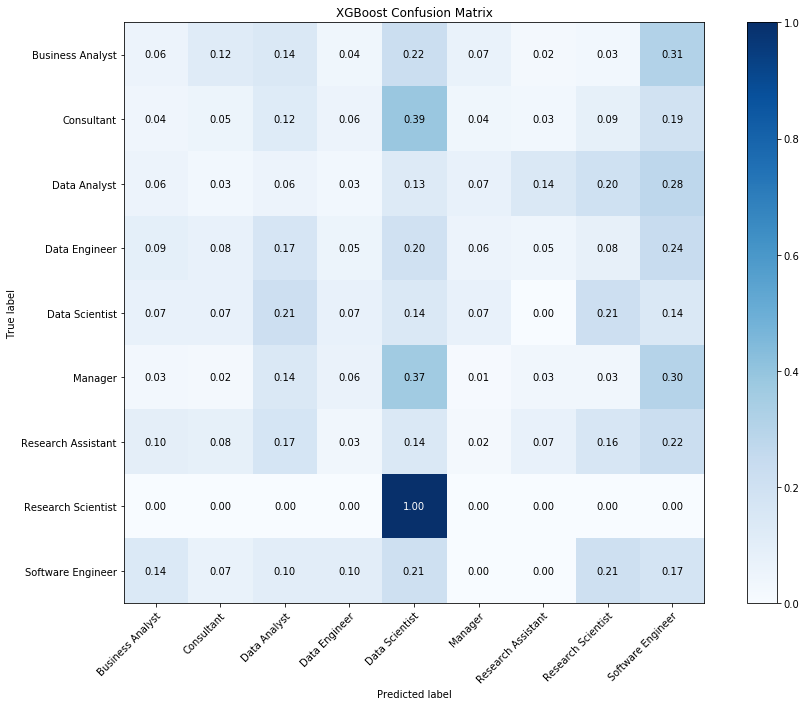

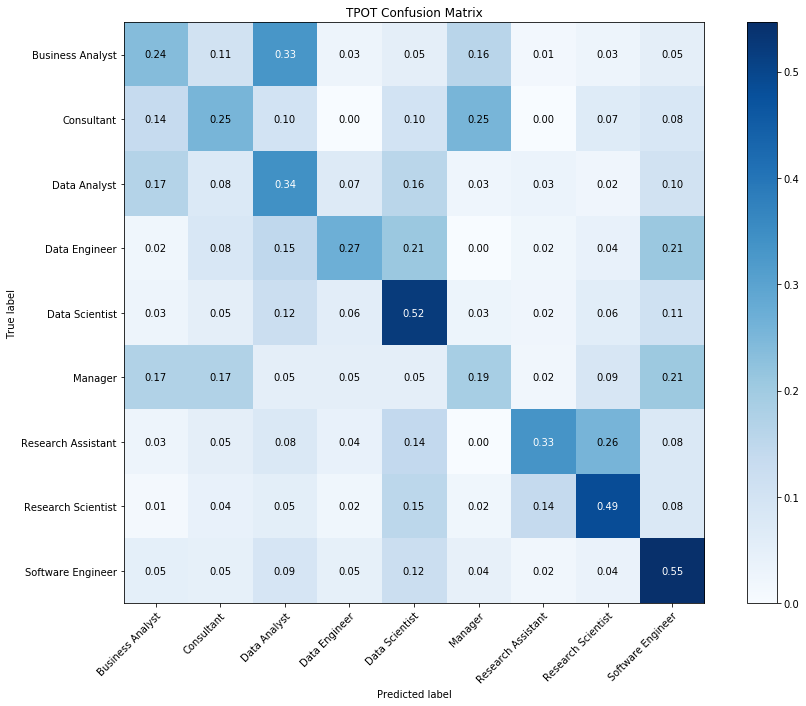

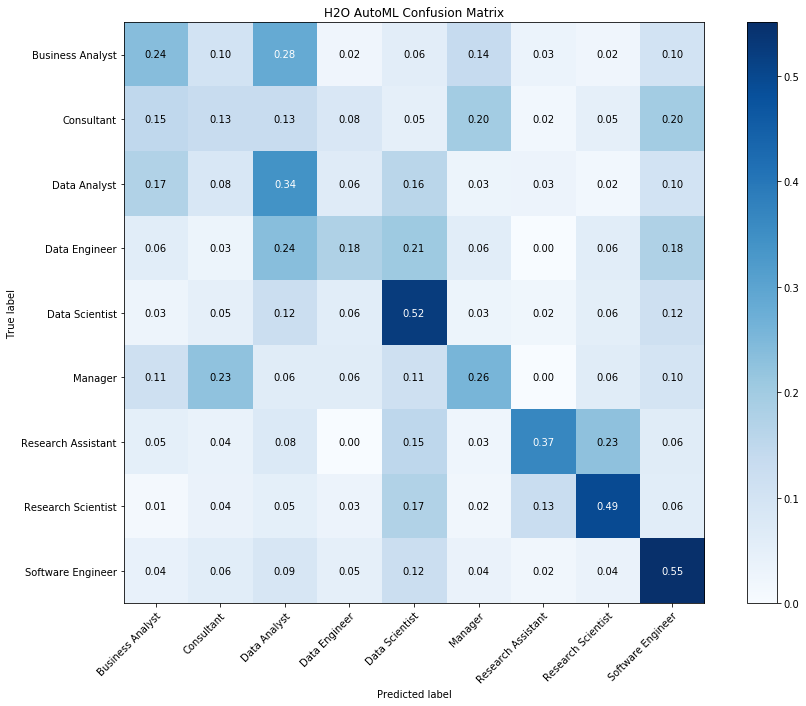

In [49]:
plot_confusion_matrix(xgb_predictions, testing_data["job_title"], 
                      classes=unique_labels(testing_data["job_title"]),
                      normalize=True,
                      title='XGBoost Confusion Matrix')

plot_confusion_matrix(tpot_predictions_unencoded, testing_data["job_title"], 
                      classes=unique_labels(testing_data["job_title"]),
                      normalize=True,
                      title='TPOT Confusion Matrix')

plot_confusion_matrix(h20_predictions_df["predict"], testing_data["job_title"], 
                      classes=unique_labels(testing_data["job_title"]),
                      normalize=True,
                      title='H2O AutoML Confusion Matrix')

# plot_confusion_matrix(predicted_titles_cloud, cloud_predictions_df.job_title, 
#                       classes=unique_labels(cloud_predictions_df["job_title"]),
#                       normalize=True,
#                       title='Cloud AutoML Confusion Matrix')

Looking at these confusion matrices, a few things jump out at me. First, that some classes seem to be more difficult than others, particularly "Consultant" and "Data Engineer". Secondly, that there's a lot of variation between models in how well they're handling specific classes. For example, the H2O model is more accurate than the TPOT model in identifying "Data Analyst" roles but less accurate at identifying "Business Analyst" roles. If one of those classes is more important to me, that's probably something I should consider when picking a model.

# Counterfactuals

This one I'm going to have you do as an exercise. You'll need to fork this notebook and run the cells above this one first. Remember to remove the Cloud AutoML bits if you're not using it!

Let's say one of my stakeholders has a background as a researcher. Based on their experience with the field, they think that someone who says that their job duties include "do_research_that_advances_the_state_of_the_art_of_machine_learning" should be classified as researcher, no matter what else they do. They want to see if our models agree with them.
To check this, there are several steps you'll need to follow:

To check this, there are several steps you'll need to follow:

* Create a copy of the `testing_data` where every row in the column "do_research_that_advances_the_state_of_the_art_of_machine_learning" is "Do research that advances the state of the art of machine learning"
* Use each of the three (or four if you're using Cloud AutoML) models to predict the job titles for this new testing dataset
* Use the `plot_confusion_matrix` function to compare these new classifications to the classifications each model made when the correct information was in that column (this will show you how the model classifications changed rather than how the new classifications compare to the ground truth)
* What results do you see? What does this suggest about how each model 

In [70]:
training_data = pd.read_csv("data/model_input/train_data_2018.csv")
testing_data = pd.read_csv("data/model_input/test_data_2018.csv")

# create testing set with all researchers according to the business expert
testing_data["do_research_that_advances_the_state_of_the_art_of_machine_learning"] = 'Do research that advances the state of the art of machine learning'

# split into predictors & target variables
X_training = training_data.drop("job_title", axis=1)
y_training = training_data["job_title"]

X_testing = testing_data.drop("job_title", axis=1)
y_testing = testing_data["job_title"]

# encoded copy of our training data for training TPOT model
encoder_X = ce.OrdinalEncoder()
X_encoded = encoder_X.fit_transform(X_training)
X_testing_encoded = encoder_X.transform(X_testing)

encoder_y = ce.OrdinalEncoder()
y_encoded = encoder_y.fit_transform(y_training)

In [71]:
X_testing = testing_data.drop("job_title", axis=1)

# redo encoding with new values
encoder_X = ce.OrdinalEncoder()
X_encoded = encoder_X.fit_transform(X_training)
X_testing_encoded = encoder_X.transform(X_testing)

train_data = h2o.H2OFrame(X_testing)
test_data = h2o.H2OFrame(list(y_testing))
test_data_h2o = train_data.cbind(test_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [72]:
# repeat preditictions with all models
tpot_predictions = exported_pipeline.predict(X_testing_encoded)
xgb_predictions = xgboost_model.predict(X_testing_encoded)
h20_predictions = h2o_model.predict(test_data_h2o)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [73]:
# convert predictions where necessary
tpot_predictions_df = pd.DataFrame(data= {'job_title': tpot_predictions})
tpot_predictions_unencoded = encoder_y.inverse_transform(tpot_predictions_df)
h20_predictions_df = h20_predictions.as_data_frame()

/Users/chhilty/Source/practical-model-evaluation/env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


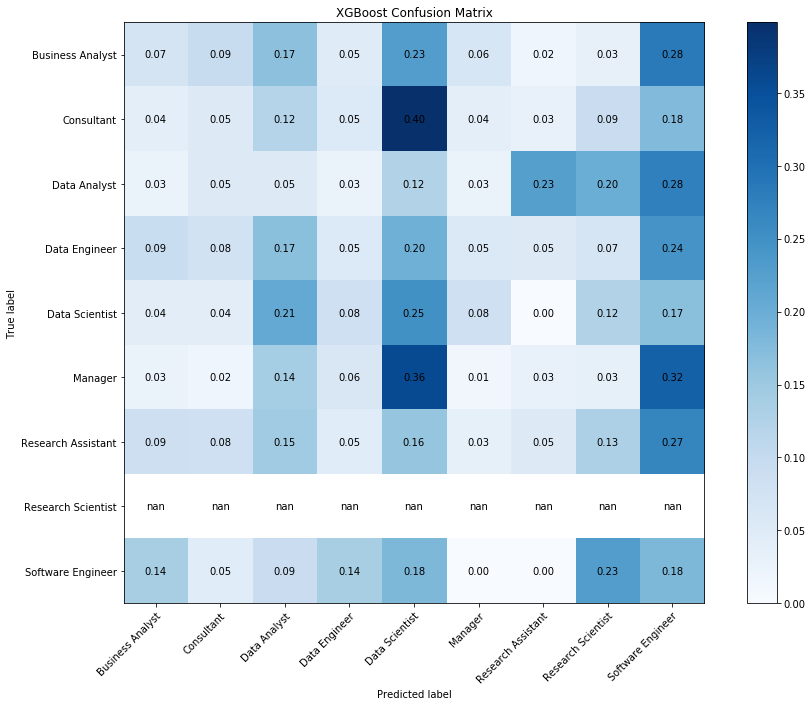

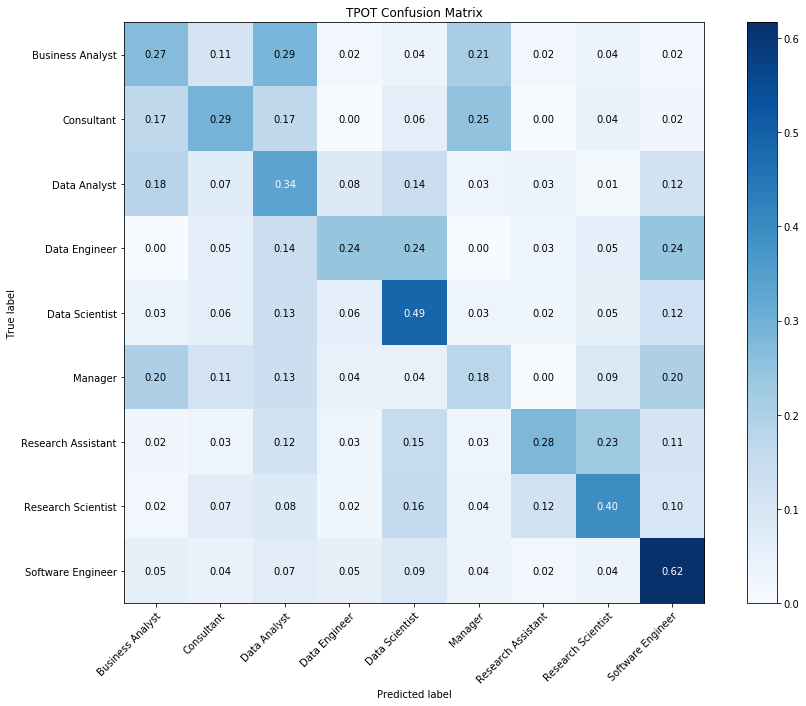

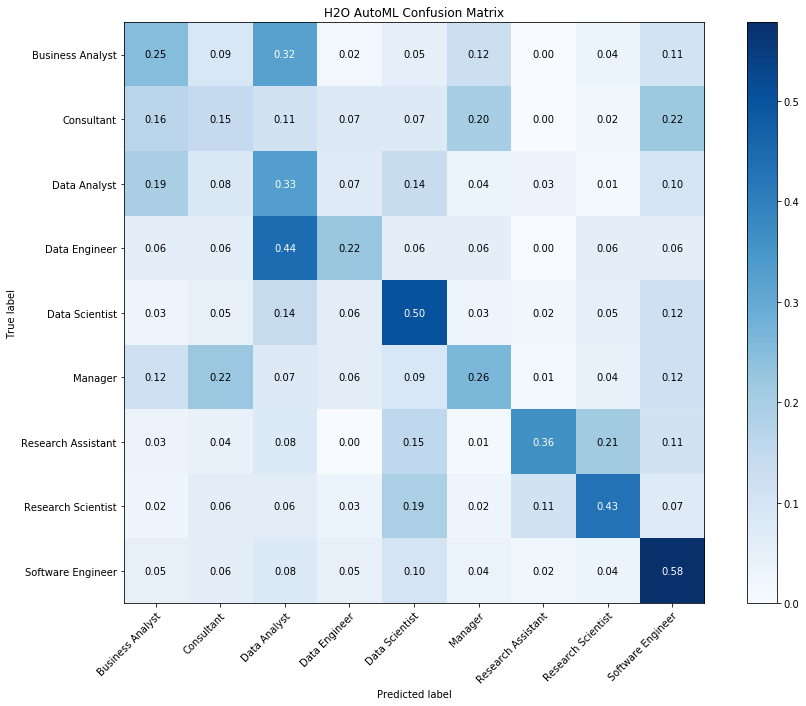

In [74]:
plot_confusion_matrix(xgb_predictions, testing_data["job_title"], 
                      classes=unique_labels(testing_data["job_title"]),
                      normalize=True,
                      title='XGBoost Confusion Matrix')

plot_confusion_matrix(tpot_predictions_unencoded, testing_data["job_title"], 
                      classes=unique_labels(testing_data["job_title"]),
                      normalize=True,
                      title='TPOT Confusion Matrix')

plot_confusion_matrix(h20_predictions_df["predict"], testing_data["job_title"], 
                      classes=unique_labels(testing_data["job_title"]),
                      normalize=True,
                      title='H2O AutoML Confusion Matrix')

# Final Exercise!

If you were a data scientist working on this problem at a company, which model would you pick to put into production? You might want to consider:

1. How long did they take to train?
2. How long does it take them to do batch inference on the held out data?
3. What's their overall accuracy? 
4. How well do they perform across cases?
5. How does their performance change if we change one of our input features?
6. Other factors not included here: what else do you think is important to consider?

Feel free to share your answers in the comments of this notebook.